### Configure environment

In [1]:
from fabrictestbed_extensions.fablib.fablib import FablibManager as fablib_manager
fablib = fablib_manager() 
conf = fablib.show_config()

Orchestrator,orchestrator.fabric-testbed.net
Credential Manager,cm.fabric-testbed.net
Core API,uis.fabric-testbed.net
Artifact Manager,artifacts.fabric-testbed.net
Token File,/home/fabric/.tokens.json
Project ID,073ee843-2310-45bd-a01f-a15d808827dc
Bastion Host,bastion.fabric-testbed.net
Bastion Username,usubutun_0000127217
Bastion Private Key File,/home/fabric/work/fabric_config/fabric_bastion_key
Slice Public Key File,/home/fabric/work/fabric_config/slice_key.pub
Slice Private Key File,/home/fabric/work/fabric_config/slice_key


### Define configuration for this experiment (example)

In [2]:
# earlier version without extra nodes for netem 
slice_name="mp-" + fablib.get_bastion_username()

node_conf = [
 {'name': "client",  'cores': 4, 'ram': 8, 'disk': 30, 'image': 'default_ubuntu_20', 'packages': ["moreutils", "net-tools", "iperf3"]}, 
 {'name': "router",  'cores': 4, 'ram': 8, 'disk': 30, 'image': 'default_ubuntu_20', 'packages': ["moreutils", "net-tools", "iperf3"]}, 
 {'name': "aggr",    'cores': 4, 'ram': 8, 'disk': 30, 'image': 'default_ubuntu_20', 'packages': ["moreutils", "net-tools", "iperf3"]}, 
 {'name': "server",  'cores': 4, 'ram': 8, 'disk': 30, 'image': 'default_ubuntu_20', 'packages': ["moreutils", "net-tools", "iperf3"]}
]
net_conf = [
 {"name": "net0", "subnet": "10.10.0.0/24", "nodes": [{"name": "client",  "addr": "10.10.0.100"}, {"name": "router",  "addr": "10.10.0.1"}]},
 {"name": "net1", "subnet": "10.10.2.0/24", "nodes": [{"name": "router",  "addr": "10.10.2.1"},   {"name": "aggr",    "addr": "10.10.2.2"}]},
 {"name": "net2", "subnet": "10.10.3.0/24", "nodes": [{"name": "router",  "addr": "10.10.3.1"},   {"name": "aggr",    "addr": "10.10.3.2"}]},
 {"name": "net3", "subnet": "10.10.4.0/24", "nodes": [{"name": "server",  "addr": "10.10.4.100"},  {"name": "aggr",   "addr": "10.10.4.1"}]}
]

route_conf = [
 {"addr": "10.10.4.0/24", "gw": "10.10.0.1", "nodes": ["client"]},
 {"addr": "10.10.3.0/24", "gw": "10.10.0.1", "nodes": ["client"]},
 {"addr": "10.10.2.0/24", "gw": "10.10.0.1", "nodes": ["client"]},
 {"addr": "10.10.0.0/24", "gw": "10.10.4.1", "nodes": ["server"]},
 {"addr": "10.10.2.0/24", "gw": "10.10.4.1", "nodes": ["server"]},
 {"addr": "10.10.3.0/24", "gw": "10.10.4.1", "nodes": ["server"]},
 # we want router-agg uses network 10.10.2.0 by default
 {"addr": "10.10.4.0/24", "gw": "10.10.2.2", "nodes": ["router"]}, 
 {"addr": "10.10.0.0/24", "gw": "10.10.2.1", "nodes": ["aggr"]}
]

# and we want router-agg uses network 10.10.3.0 for marked packets
# to achieve this we will create a second routing table at these nodes
# to be used when routing marked packets (marking by round-robin or flow hashing)
marked_route_conf = [
 {"addr": "10.10.4.0/24", "gw": "10.10.3.2", "nodes": ["router"]},
 {"addr": "10.10.0.0/24", "gw": "10.10.3.1", "nodes": ["aggr"]}
]


exp_conf = {'cores': sum([ n['cores'] for n in node_conf]), 'nic': sum([len(n['nodes']) for n in net_conf]) }

In [2]:
# current version with additional nodes for netem functionality
slice_name="mp-" + fablib.get_bastion_username()

node_conf = [
 {'name': "client",  'cores': 4, 'ram': 8, 'disk': 30, 'image': 'default_ubuntu_20', 'packages': ["moreutils", "net-tools", "iperf3"]}, 
 {'name': "router",  'cores': 4, 'ram': 8, 'disk': 30, 'image': 'default_ubuntu_20', 'packages': ["moreutils", "net-tools", "iperf3"]}, 
 {'name': "aggr",    'cores': 4, 'ram': 8, 'disk': 30, 'image': 'default_ubuntu_20', 'packages': ["moreutils", "net-tools", "iperf3"]}, 
 {'name': "del1",  'cores': 4, 'ram': 8, 'disk': 30, 'image': 'default_ubuntu_20', 'packages': ["moreutils", "net-tools", "iperf3"]}, 
 {'name': "del2",    'cores': 4, 'ram': 8, 'disk': 30, 'image': 'default_ubuntu_20', 'packages': ["moreutils", "net-tools", "iperf3"]}, 
 {'name': "server",  'cores': 4, 'ram': 8, 'disk': 30, 'image': 'default_ubuntu_20', 'packages': ["moreutils", "net-tools", "iperf3"]}
]
net_conf = [
 {"name": "net0", "subnet": "10.10.0.0/24", "nodes": [{"name": "client",  "addr": "10.10.0.100"}, {"name": "router",  "addr": "10.10.0.1"}]},
 {"name": "net1", "subnet": "10.10.2.0/24", "nodes": [{"name": "router",  "addr": "10.10.2.1"},   {"name": "del1",    "addr": "10.10.2.2"}]},
 {"name": "net2", "subnet": "10.10.3.0/24", "nodes": [{"name": "router",  "addr": "10.10.3.1"},   {"name": "del2",    "addr": "10.10.3.2"}]},
 {"name": "net1x", "subnet": "10.10.20.0/24", "nodes": [{"name": "del1",  "addr": "10.10.20.1"},   {"name": "aggr",    "addr": "10.10.20.2"}]},
 {"name": "net2x", "subnet": "10.10.30.0/24", "nodes": [{"name": "del2",  "addr": "10.10.30.1"},   {"name": "aggr",    "addr": "10.10.30.2"}]},
 {"name": "net3", "subnet": "10.10.4.0/24", "nodes": [{"name": "server",  "addr": "10.10.4.100"},  {"name": "aggr",   "addr": "10.10.4.1"}]}
]

route_conf = [
 {"addr": "10.10.0.0/16", "gw": "10.10.0.1", "nodes": ["client"]},
 {"addr": "10.10.0.0/16", "gw": "10.10.4.1", "nodes": ["server"]},
 {"addr": "10.10.4.0/24", "gw": "10.10.20.2", "nodes": ["del1"]}, 
 {"addr": "10.10.0.0/24", "gw": "10.10.2.1", "nodes": ["del1"]},
 {"addr": "10.10.4.0/24", "gw": "10.10.30.2", "nodes": ["del2"]}, 
 {"addr": "10.10.0.0/24", "gw": "10.10.3.1", "nodes": ["del2"]},
 {"addr": "10.10.20.0/24", "gw": "10.10.2.2", "nodes": ["router"]}, 
 {"addr": "10.10.2.0/24", "gw": "10.10.20.1", "nodes": ["aggr"]},
 {"addr": "10.10.30.0/24", "gw": "10.10.3.2", "nodes": ["router"]}, 
 {"addr": "10.10.3.0/24", "gw": "10.10.30.1", "nodes": ["aggr"]},
 # we want router-agg uses network 10.10.2(0).0 by default to reach the endpoints
 {"addr": "10.10.4.0/24", "gw": "10.10.2.2", "nodes": ["router"]}, 
 {"addr": "10.10.0.0/24", "gw": "10.10.20.1", "nodes": ["aggr"]}
]

# and we want router-agg uses network 10.10.3(0).0 for marked packets
# to achieve this we will create a second routing table at these nodes
# to be used when routing marked packets (marking by round-robin or flow hashing)
marked_route_conf = [
 {"addr": "10.10.4.0/24", "gw": "10.10.3.2", "nodes": ["router"]},
 {"addr": "10.10.0.0/24", "gw": "10.10.30.1", "nodes": ["aggr"]}
]


exp_conf = {'cores': sum([ n['cores'] for n in node_conf]), 'nic': sum([len(n['nodes']) for n in net_conf]) }

### Reserve resources

Now, we are ready to reserve resources!

First, make sure you don’t already have a slice with this name:

In [3]:
try:
    slice = fablib.get_slice(slice_name)
    print("You already have a slice by this name!")
    print("If you previously reserved resources, skip to the 'log in to resources' section.")
except:
    print("You don't have a slice named %s yet." % slice_name)
    print("Continue to the next step to make one.")
    slice = fablib.new_slice(name=slice_name)

You already have a slice by this name!
If you previously reserved resources, skip to the 'log in to resources' section.


We will select a random site that has sufficient resources for our experiment:

In [5]:
while True:
    site_name = fablib.get_random_site()
    if ( (fablib.resources.get_core_available(site_name) > 1.2*exp_conf['cores']) and
        (fablib.resources.get_component_available(site_name, 'SharedNIC-ConnectX-6') > 1.2**exp_conf['nic']) ):
        break

fablib.show_site(site_name)

Name,CLEM
State,Active
Address,"340 Computer Court,Anderson,SC 29625"
Location,"(34.5865435, -82.8212889)"
PTP Capable,True
Hosts,3
CPUs,6
Cores Available,212
Cores Capacity,384
Cores Allocated,172
Ram Available,842


'<pandas.io.formats.style.Styler object at 0x7a441d91e250>'

Then we will add hosts and network segments:

In [6]:
# this cell sets up the nodes
for n in node_conf:
    slice.add_node(name=n['name'], site=site_name, 
                   cores=n['cores'], 
                   ram=n['ram'], 
                   disk=n['disk'], 
                   image=n['image'])

In [7]:
# this cell sets up the network segments
for n in net_conf:
    ifaces = [slice.get_node(node["name"]).add_component(model="NIC_Basic", 
                                                 name=n["name"]).get_interfaces()[0] for node in n['nodes'] ]
    slice.add_l2network(name=n["name"], type='L2Bridge', interfaces=ifaces)

The following cell submits our request to the FABRIC site. The output of this cell will update automatically as the status of our request changes.

-   While it is being prepared, the “State” of the slice will appear as “Configuring”.
-   When it is ready, the “State” of the slice will change to “StableOK”.

You may prefer to walk away and come back in a few minutes (for simple slices) or a few tens of minutes (for more complicated slices with many resources).

In [8]:
slice.submit()


Retry: 11, Time: 351 sec


ID,da584ecb-f019-4b6b-a3f5-323b9233d555
Name,mp-usubutun_0000127217
Lease Expiration (UTC),2025-01-17 14:04:13 +0000
Lease Start (UTC),2025-01-16 14:04:13 +0000
Project ID,073ee843-2310-45bd-a01f-a15d808827dc
State,StableOK


ID,Name,Cores,RAM,Disk,Image,Image Type,Host,Site,Username,Management IP,State,Error,SSH Command,Public SSH Key File,Private SSH Key File
935392d3-559c-44ea-8ae5-99a16e02b3a6,aggr,4,8,100,default_ubuntu_20,qcow2,clem-w1.fabric-testbed.net,CLEM,ubuntu,2620:103:a006:12:f816:3eff:fe7d:3df0,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:103:a006:12:f816:3eff:fe7d:3df0,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
fd57d6d2-fbfa-4b3d-bd44-6c0504e3ea6a,client,4,8,100,default_ubuntu_20,qcow2,clem-w2.fabric-testbed.net,CLEM,ubuntu,2620:103:a006:12:f816:3eff:fed1:fdae,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:103:a006:12:f816:3eff:fed1:fdae,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
8e2636c5-9caa-41a4-bf81-bdfee1b80acb,del1,4,8,100,default_ubuntu_20,qcow2,clem-w1.fabric-testbed.net,CLEM,ubuntu,2620:103:a006:12:f816:3eff:fe35:22a8,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:103:a006:12:f816:3eff:fe35:22a8,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
c0d60bf7-2435-437b-8839-754d16273825,del2,4,8,100,default_ubuntu_20,qcow2,clem-w1.fabric-testbed.net,CLEM,ubuntu,2620:103:a006:12:f816:3eff:fefa:b596,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:103:a006:12:f816:3eff:fefa:b596,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
46515764-5c22-4bb5-b59d-1c445d1fa5e8,router,4,8,100,default_ubuntu_20,qcow2,clem-w2.fabric-testbed.net,CLEM,ubuntu,2620:103:a006:12:f816:3eff:fe0c:546a,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:103:a006:12:f816:3eff:fe0c:546a,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
53090dae-6456-4b0f-aeb0-529470f62bc1,server,4,8,100,default_ubuntu_20,qcow2,clem-w3.fabric-testbed.net,CLEM,ubuntu,2620:103:a006:12:f816:3eff:fe48:d67e,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:103:a006:12:f816:3eff:fe48:d67e,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key


ID,Name,Layer,Type,Site,Subnet,Gateway,State,Error
bf72346b-ff65-48eb-a5b5-a5f131c06517,net0,L2,L2Bridge,CLEM,None,None,Active,
c426d30d-d7c0-4793-8dc3-79a35988acf8,net1,L2,L2Bridge,CLEM,None,None,Active,
a8d0120b-95aa-4383-bfbe-f1042a15f06c,net1x,L2,L2Bridge,CLEM,None,None,Active,
74768951-6be7-454a-ac14-1b87001dd045,net2,L2,L2Bridge,CLEM,None,None,Active,
8f2dc299-6083-442d-8f33-b1c8419a5bf7,net2x,L2,L2Bridge,CLEM,None,None,Active,
4d60c71b-a135-42b5-9d6d-49feb7f8c5d9,net3,L2,L2Bridge,CLEM,None,None,Active,


Name,Short Name,Node,Network,Bandwidth,Mode,VLAN,MAC,Physical Device,Device,IP Address,Numa Node,Switch Port
client-net0-p1,p1,client,net0,100,config,,02:88:DA:4F:7A:E8,enp7s0,enp7s0,fe80::88:daff:fe4f:7ae8,4,HundredGigE0/0/0/9
router-net0-p1,p1,router,net0,100,config,,2E:3E:BF:85:F4:61,enp9s0,enp9s0,fe80::2c3e:bfff:fe85:f461,4,HundredGigE0/0/0/9
router-net1-p1,p1,router,net1,100,config,,02:DA:D0:DE:84:4D,enp7s0,enp7s0,fe80::da:d0ff:fede:844d,4,HundredGigE0/0/0/9
router-net2-p1,p1,router,net2,100,config,,02:DC:A4:AB:D6:D8,enp8s0,enp8s0,fe80::dc:a4ff:feab:d6d8,4,HundredGigE0/0/0/9
aggr-net3-p1,p1,aggr,net3,100,config,,2A:F3:42:9A:19:AB,enp9s0,enp9s0,fe80::28f3:42ff:fe9a:19ab,6,HundredGigE0/0/0/5
aggr-net1x-p1,p1,aggr,net1x,100,config,,26:EC:72:3C:58:74,enp7s0,enp7s0,fe80::24ec:72ff:fe3c:5874,6,HundredGigE0/0/0/5
aggr-net2x-p1,p1,aggr,net2x,100,config,,2A:ED:72:0B:5C:21,enp8s0,enp8s0,fe80::28ed:72ff:fe0b:5c21,6,HundredGigE0/0/0/5
del1-net1-p1,p1,del1,net1,100,config,,2E:73:40:2D:D5:B7,enp8s0,enp8s0,fe80::2c73:40ff:fe2d:d5b7,6,HundredGigE0/0/0/5
del1-net1x-p1,p1,del1,net1x,100,config,,2E:46:FE:9A:FE:A2,enp7s0,enp7s0,fe80::2c46:feff:fe9a:fea2,6,HundredGigE0/0/0/5
del2-net2x-p1,p1,del2,net2x,100,config,,2E:BB:9E:37:1A:51,enp7s0,enp7s0,fe80::2cbb:9eff:fe37:1a51,6,HundredGigE0/0/0/5



Time to print interfaces 388 seconds


'da584ecb-f019-4b6b-a3f5-323b9233d555'

In [9]:
slice.get_state()
slice.wait_ssh(progress=True)

Waiting for slice . Slice state: StableOK
Waiting for ssh in slice . ssh successful


True

### Extend your slice

If you don’t plan to finish an experiment in one day, you can extend your slice. The following cell extends your reservation for 7 days.

In [ ]:
from datetime import datetime
from datetime import timezone
from datetime import timedelta

# Set end date to 7 days from now
end_date = (datetime.now(timezone.utc) + timedelta(days=7)).strftime("%Y-%m-%d %H:%M:%S %z")
slice.renew(end_date)

### Configure resources

Next, we will configure the resources so they are ready to use.

In [10]:
slice = fablib.get_slice(name=slice_name)

In [11]:
# install packages
# this will take a while and will run in background while you do other steps
for n in node_conf:
    if len(n['packages']):
        node = slice.get_node(n['name'])
        pkg = " ".join(n['packages'])
        node.execute_thread("sudo apt update; sudo DEBIAN_FRONTEND=noninteractive apt -y install %s" % pkg)

In [12]:
# bring interfaces up and either assign an address (if there is one) or flush address
from ipaddress import ip_address, IPv4Address, IPv4Network

for net in net_conf:
    for n in net['nodes']:
        if_name = n['name'] + '-' + net['name'] + '-p1'
        iface = slice.get_interface(if_name)
        iface.ip_link_up()
        if n['addr']:
            iface.ip_addr_add(addr=n['addr'], subnet=IPv4Network(net['subnet']))
        else:
            iface.get_node().execute("sudo ip addr flush dev %s"  % iface.get_device_name())

In [13]:
# make sure all interfaces are brought up
for iface in slice.get_interfaces():
    iface.ip_link_up()

In [14]:
# prepare a "hosts" file that has names and addresses of every node
hosts_txt = [ "%s\t%s" % ( n['addr'], n['name'] ) for net in net_conf  for n in net['nodes'] if type(n) is dict and n['addr']]
for n in slice.get_nodes():
    for h in hosts_txt:
        n.execute("echo %s | sudo tee -a /etc/hosts" % h)

10.10.0.100 client
10.10.0.1 router
10.10.2.1 router
10.10.2.2 del1
10.10.3.1 router
10.10.3.2 del2
10.10.20.1 del1
10.10.20.2 aggr
10.10.30.1 del2
10.10.30.2 aggr
10.10.4.100 server
10.10.4.1 aggr
10.10.0.100 client
10.10.0.1 router
10.10.2.1 router
10.10.2.2 del1
10.10.3.1 router
10.10.3.2 del2
10.10.20.1 del1
10.10.20.2 aggr
10.10.30.1 del2
10.10.30.2 aggr
10.10.4.100 server
10.10.4.1 aggr
10.10.0.100 client
10.10.0.1 router
10.10.2.1 router
10.10.2.2 del1
10.10.3.1 router
10.10.3.2 del2
10.10.20.1 del1
10.10.20.2 aggr
10.10.30.1 del2
10.10.30.2 aggr
10.10.4.100 server
10.10.4.1 aggr
10.10.0.100 client
10.10.0.1 router
10.10.2.1 router
10.10.2.2 del1
10.10.3.1 router
10.10.3.2 del2
10.10.20.1 del1
10.10.20.2 aggr
10.10.30.1 del2
10.10.30.2 aggr
10.10.4.100 server
10.10.4.1 aggr
10.10.0.100 client
10.10.0.1 router
10.10.2.1 router
10.10.2.2 del1
10.10.3.1 router
10.10.3.2 del2
10.10.20.1 del1
10.10.20.2 aggr
10.10.30.1 del2
10.10.30.2 aggr
10.10.4.100 server
10.10.4.1 aggr
10.10.0.10

In [15]:
# enable IPv4 forwarding on all nodes
for n in slice.get_nodes():
    n.execute("sudo sysctl -w net.ipv4.ip_forward=1")

net.ipv4.ip_forward = 1
net.ipv4.ip_forward = 1
net.ipv4.ip_forward = 1
net.ipv4.ip_forward = 1
net.ipv4.ip_forward = 1
net.ipv4.ip_forward = 1


In [16]:
# set up static routes
for rt in route_conf:
    for n in rt['nodes']:
        slice.get_node(name=n).ip_route_add(subnet=IPv4Network(rt['addr']), gateway=rt['gw'])

# set up static routes for the alternate path at the table number
ALT_TABLE_NUM = 100
FWD_PKT_MARK = 3
for rt in marked_route_conf:
    for n in rt['nodes']:
        slice.get_node(name=n).execute(f"sudo ip route add {IPv4Network(rt['addr'])} via {rt['gw']} table {ALT_TABLE_NUM}")
        slice.get_node(name=n).execute(f"sudo ip rule add fwmark {FWD_PKT_MARK} table {ALT_TABLE_NUM}")
        

In [17]:
# turn off segmentation offload on interfaces
for iface in slice.get_interfaces():
    iface_name = iface.get_device_name()
    n = iface.get_node()
    offloads = ["gro", "lro", "gso", "tso"]
    for offload in offloads:
        n.execute("sudo ethtool -K %s %s off" % (iface_name, offload))

### Draw the network topology

The following cell will draw the network topology, for your reference. The interface name and addresses of each experiment interface will be shown on the drawing.

In [18]:
l2_nets = [(n.get_name(), {'color': 'lavender'}) for n in slice.get_l2networks() ]
l3_nets = [(n.get_name(), {'color': 'pink'}) for n in slice.get_l3networks() ]
hosts   =   [(n.get_name(), {'color': 'lightblue'}) for n in slice.get_nodes()]
nodes = l2_nets + l3_nets + hosts
ifaces = [iface.toDict() for iface in slice.get_interfaces()]
edges = [(iface['network'], iface['node'], 
          {'label': iface['physical_dev'] + '\n' + iface['ip_addr'] + '\n' + iface['mac']}) for iface in ifaces]

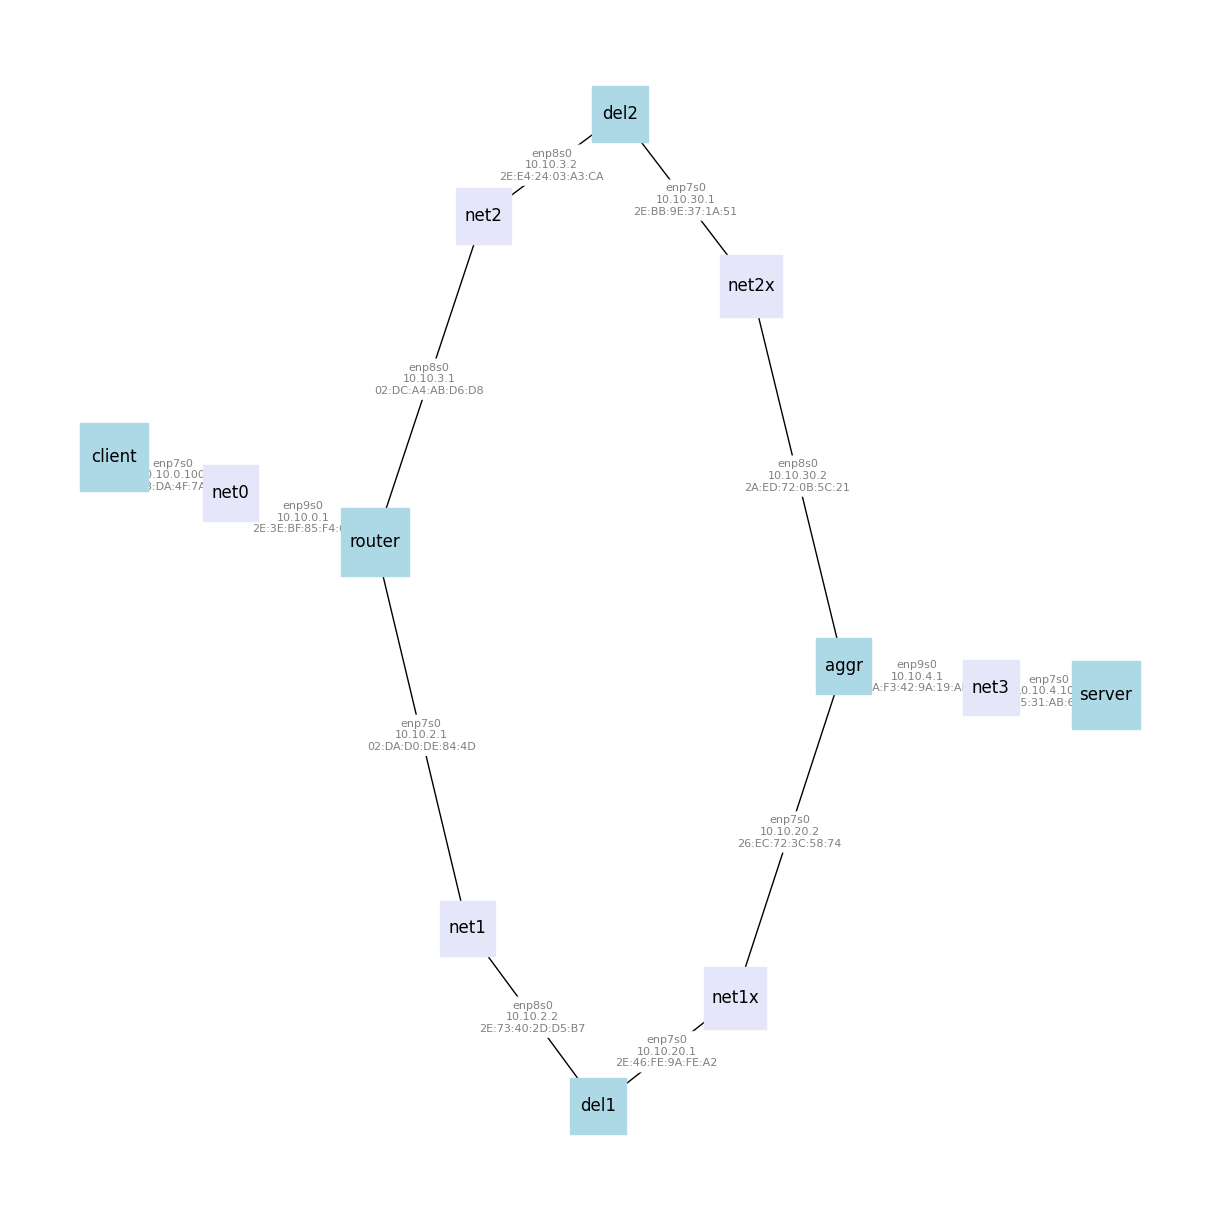

In [19]:
import networkx as nx
import matplotlib.pyplot as plt
plt.figure(figsize=(len(nodes),len(nodes)))
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
pos = nx.spring_layout(G)
nx.draw(G, pos, node_shape='s',  
        node_color=[n[1]['color'] for n in nodes], 
        node_size=[len(n[0])*400 for n in nodes],  
        with_labels=True);
nx.draw_networkx_edge_labels(G,pos,
                             edge_labels=nx.get_edge_attributes(G,'label'),
                             font_color='gray',  font_size=8, rotate=False);

### Log into resources

Now, we are finally ready to log in to our resources over SSH! Run the following cells, and observe the table output - you will see an SSH command for each of the resources in your topology.

In [4]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
slice_info = [{'Name': n.get_name(), 'SSH command': n.get_ssh_command()} for n in slice.get_nodes()]
pd.DataFrame(slice_info).set_index('Name')

,SSH command
Name,
client,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:103:a006:12:f816:3eff:fed1:fdae
router,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:103:a006:12:f816:3eff:fe0c:546a
aggr,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:103:a006:12:f816:3eff:fe7d:3df0
del1,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:103:a006:12:f816:3eff:fe35:22a8
del2,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:103:a006:12:f816:3eff:fefa:b596
server,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:103:a006:12:f816:3eff:fe48:d67e


Now, you can open an SSH session on any of the resources as follows:

-   in Jupyter, from the menu bar, use File \> New \> Terminal to open a new terminal.
-   copy an SSH command from the table, and paste it into the terminal. (Note that each SSH command is a single line, even if the display wraps the text to a second line! When you copy and paste it, paste it all together.)

You can repeat this process (open several terminals) to start a session on each resource. Each terminal session will have a tab in the Jupyter environment, so that you can easily switch between them.

### Configure queues

In [221]:
#df = None

In [776]:
# all of the experiment factors. For now, just one value. Later, we make these lists
# and we can systematically run a full factorial experiment.
exp = {
    'link_rate':  130,  # rate of interface at endpoints and router reverse path, in Mbps.
    'link_buf':   2.6,  # size of interface at endpoints and router reverse path, in Mbit.
    #not anymore 'link_delay': 10,   # in ms, applied at aggr only
    'p1_rate':    50,  # rate of router egress interface for path 1, in Mbps 
    'p1_buf':     0.25,  # size of router egress buffer for path 1, in Mbit
    'p1_delay':   21, # delay of router egress interface for path 1, in ms 
    'p2_rate':    50,  # rate of router egress interface for path 2, in Mbps 
    'p2_buf':     0.25,  # size of router egress buffer for path 2, in Mbit
    'p2_delay':   5, # delay of router egress interface for path 2, in ms 
    'p2_prob':    0.5,  # probability of being marked for path 2 
    'lb_type':    "packet", # can be "packet" or "flow"
    'trial':      1,     # trial index
    'alg':        3 # 1 - RACK, 2 - adapthresh, 3 - 3dupack
}

In [777]:
# set loss detection / recovery algorithm (at each node)

alg_command = ""
if exp['alg'] == 1:
    alg_command = "sudo sysctl -w net.ipv4.tcp_recovery=1 net.ipv4.tcp_max_reordering=300 net.ipv4.tcp_sack=1 net.ipv4.tcp_dsack=1 net.ipv4.tcp_no_metrics_save=1"
elif exp['alg'] == 2:
    alg_command = "sudo sysctl -w net.ipv4.tcp_recovery=0 net.ipv4.tcp_max_reordering=300 net.ipv4.tcp_sack=1 net.ipv4.tcp_dsack=1 net.ipv4.tcp_no_metrics_save=1"
elif exp['alg'] == 3:
    alg_command = "sudo sysctl -w net.ipv4.tcp_recovery=0 net.ipv4.tcp_max_reordering=3 net.ipv4.tcp_sack=1 net.ipv4.tcp_dsack=1 net.ipv4.tcp_no_metrics_save=1"

for n in slice.get_nodes():
    n.execute(alg_command)

net.ipv4.tcp_recovery = 0
net.ipv4.tcp_max_reordering = 3
net.ipv4.tcp_sack = 1
net.ipv4.tcp_dsack = 1
net.ipv4.tcp_no_metrics_save = 1
net.ipv4.tcp_recovery = 0
net.ipv4.tcp_max_reordering = 3
net.ipv4.tcp_sack = 1
net.ipv4.tcp_dsack = 1
net.ipv4.tcp_no_metrics_save = 1
net.ipv4.tcp_recovery = 0
net.ipv4.tcp_max_reordering = 3
net.ipv4.tcp_sack = 1
net.ipv4.tcp_dsack = 1
net.ipv4.tcp_no_metrics_save = 1
net.ipv4.tcp_recovery = 0
net.ipv4.tcp_max_reordering = 3
net.ipv4.tcp_sack = 1
net.ipv4.tcp_dsack = 1
net.ipv4.tcp_no_metrics_save = 1
net.ipv4.tcp_recovery = 0
net.ipv4.tcp_max_reordering = 3
net.ipv4.tcp_sack = 1
net.ipv4.tcp_dsack = 1
net.ipv4.tcp_no_metrics_save = 1
net.ipv4.tcp_recovery = 0
net.ipv4.tcp_max_reordering = 3
net.ipv4.tcp_sack = 1
net.ipv4.tcp_dsack = 1
net.ipv4.tcp_no_metrics_save = 1


In [778]:
client_node = slice.get_node(name="client")
client_iface  = client_node.get_interface(network_name = "net0")
client_ifname = client_iface.get_device_name()

client_tc_cmd = '''
    sudo tc qdisc del dev {iface} root  
    sudo tc qdisc add dev {iface} root handle 1: htb default 3  
    sudo tc class add dev {iface} parent 1: classid 1:3 htb rate {rate}Mbit  
    sudo tc qdisc add dev {iface} parent 1:3 bfifo limit  {buf}mbit
    '''.format(iface=client_ifname, rate=exp['link_rate'], buf=exp['link_buf'])

client_node.execute(client_tc_cmd)


('', '')

In [779]:
router_node = slice.get_node(name="router")
router_iface_0  = router_node.get_interface(network_name = "net0")
router_iface_1  = router_node.get_interface(network_name = "net1")
router_iface_2  = router_node.get_interface(network_name = "net2")
router_ifname_0 = router_iface_0.get_device_name()
router_ifname_1 = router_iface_1.get_device_name()
router_ifname_2 = router_iface_2.get_device_name()

router_tc_cmd = '''

    sudo tc qdisc del dev {iface1} root  
    sudo tc qdisc add dev {iface1} root handle 1: htb default 3  
    sudo tc class add dev {iface1} parent 1: classid 1:3 htb rate {r1}Mbit quantum 1514
    sudo tc qdisc add dev {iface1} parent 1:3 bfifo limit {b1}mbit

    sudo tc qdisc del dev {iface2} root  
    sudo tc qdisc add dev {iface2} root handle 1: htb default 3  
    sudo tc class add dev {iface2} parent 1: classid 1:3 htb rate {r2}Mbit quantum 1514 
    sudo tc qdisc add dev {iface2} parent 1:3 bfifo limit {b2}mbit

    # configure reverse path
    sudo tc qdisc del dev {iface0} root  
    sudo tc qdisc add dev {iface0} root handle 1: htb default 3  
    sudo tc class add dev {iface0} parent 1: classid 1:3 htb rate {rl}Mbit  
    sudo tc qdisc add dev {iface0} parent 1:3 bfifo limit {bl}mbit 

    '''.format(iface0=router_ifname_0, iface1=router_ifname_1, iface2=router_ifname_2, 
            r1=exp['p1_rate'],   b1=exp['p1_buf'], d1=exp['p1_delay'], 
            r2=exp['p2_rate'],   b2=exp['p2_buf'], d2=exp['p2_delay'],
            rl=exp['link_rate'], bl=exp['link_buf'])

#print(router_tc_cmd)
router_node.execute(router_tc_cmd)

('', '')

In [780]:
del1_node = slice.get_node(name="del1")
del1_iface_0  = del1_node.get_interface(network_name = "net1")
del1_iface_1  = del1_node.get_interface(network_name = "net1x")
del1_ifname_0 = del1_iface_0.get_device_name()
del1_ifname_1 = del1_iface_1.get_device_name()

del1_tc_cmd = '''

    sudo tc qdisc del dev {iface0} root  
    sudo tc qdisc add dev {iface0} root netem delay {d}ms  

    sudo tc qdisc del dev {iface1} root  
    sudo tc qdisc add dev {iface1} root netem delay {d}ms  


    '''.format(iface0=del1_ifname_0, iface1=del1_ifname_1, 
                r=exp['p1_rate'],   d=exp['p1_delay'])

#print(del1_tc_cmd)
del1_node.execute(del1_tc_cmd)

del2_node = slice.get_node(name="del2")
del2_iface_0  = del2_node.get_interface(network_name = "net2")
del2_iface_1  = del2_node.get_interface(network_name = "net2x")
del2_ifname_0 = del2_iface_0.get_device_name()
del2_ifname_1 = del2_iface_1.get_device_name()

del2_tc_cmd = '''

    sudo tc qdisc del dev {iface0} root  
    sudo tc qdisc add dev {iface0} root netem delay {d}ms  

    sudo tc qdisc del dev {iface1} root  
    sudo tc qdisc add dev {iface1} root netem delay {d}ms  

    '''.format(iface0=del1_ifname_0, iface1=del1_ifname_1, 
               r=exp['p2_rate'],  d=exp['p2_delay'])

#print(del2_tc_cmd)
del2_node.execute(del2_tc_cmd)

('', '')

In [781]:
aggr_node = slice.get_node(name="aggr")
aggr_iface_3  = aggr_node.get_interface(network_name = "net3")
aggr_iface_1  = aggr_node.get_interface(network_name = "net1x")
aggr_iface_2  = aggr_node.get_interface(network_name = "net2x")
aggr_ifname_3 = aggr_iface_3.get_device_name()
aggr_ifname_1 = aggr_iface_1.get_device_name()
aggr_ifname_2 = aggr_iface_2.get_device_name()

aggr_tc_cmd = '''

    sudo tc qdisc del dev {iface1} root  
    sudo tc qdisc add dev {iface1} root handle 1: htb default 3  
    sudo tc class add dev {iface1} parent 1: classid 1:3 htb rate {r1}Mbit quantum 1514
    sudo tc qdisc add dev {iface1} parent 1:3 bfifo limit {b1}mbit  

    sudo tc qdisc del dev {iface2} root  
    sudo tc qdisc add dev {iface2} root handle 1: htb default 3  
    sudo tc class add dev {iface2} parent 1: classid 1:3 htb rate {r2}Mbit quantum 1514 
    sudo tc qdisc add dev {iface2} parent 1:3 bfifo limit {b2}mbit

    # configure path to server

    sudo tc qdisc del dev {iface3} root  
    sudo tc qdisc add dev {iface3} root handle 1: htb default 3  
    sudo tc class add dev {iface3} parent 1:2 classid 1:3 htb rate {rl}Mbit quantum 1514 
    sudo tc qdisc add dev {iface3} parent 1:3 bfifo limit {bl}mbit 
    
    
    '''.format(iface3=aggr_ifname_3, iface1=aggr_ifname_1, iface2=aggr_ifname_2, 
            r1=exp['p1_rate'],   b1=exp['p1_buf'],   d1=exp['p1_delay'], 
            r2=exp['p2_rate'],   b2=exp['p2_buf'],   d2=exp['p2_delay'],
            rl=exp['link_rate'], bl=exp['link_buf']) #,dl=exp['link_delay'])
            
aggr_node.execute(aggr_tc_cmd)

('', '')

In [782]:
server_node = slice.get_node(name="server")
server_iface  = server_node.get_interface(network_name = "net3")
server_ifname = server_iface.get_device_name()

server_tc_cmd = '''
    sudo tc qdisc del dev {iface} root  
    sudo tc qdisc add dev {iface} root handle 1: htb default 3  
    sudo tc class add dev {iface} parent 1:2 classid 1:3 htb rate {rate}Mbit  
    sudo tc qdisc add dev {iface} parent 1:3 bfifo limit  {buf}mbit 
    '''.format(iface=server_ifname, rate=exp['link_rate'], buf=exp['link_buf'])


server_node.execute(server_tc_cmd)

('', '')

Now let's apply the pakcet tagging rules to setup per-packet or per-flow forwarding

In [783]:
#flush all iptables rules
router_node.execute("sudo iptables -t mangle -F")

('', '')

In [784]:

if exp['lb_type']=="packet":
    router_iptables_cmd = '''
        # flush first!
        sudo iptables -t mangle -F
        sudo iptables -A PREROUTING -m statistic --mode nth --every {n_packets} --packet 0 -t mangle --destination 10.10.4.100/24 --source 10.10.0.0/16 -j MARK --set-mark 3
        sudo iptables -A PREROUTING -m mark --mark 3 -t mangle -j RETURN
    '''.format(n_packets=int(1/exp['p2_prob']) )

    
if exp['lb_type']=="flow":

    router_ifname_0 = router_iface_0.get_device_name()
    
    router_iptables_cmd = '''
        # flush first!
        sudo iptables -t mangle -F
        # Mark all flows to 2
        sudo iptables -t mangle -A PREROUTING -i {iface0} -m conntrack --ctstate NEW -j CONNMARK --set-mark 2
        # Mark half of the flows to 1
        sudo iptables -t mangle -A PREROUTING -i {iface0} -m conntrack --ctstate NEW -m statistic --mode random --probability {prob} -j CONNMARK --set-mark 1
        # restore and overwrite (?) the mark of previously marked flows
        sudo iptables -t mangle -A PREROUTING -i {iface0} -m conntrack --ctstate ESTABLISHED,RELATED -j CONNMARK --restore-mark

        # Mark packets 3 if they belong to flows marked 1
        sudo iptables -t mangle -A PREROUTING -m connmark --mark 1 -j MARK --set-mark 3
        # if a packet is marked with 3 return
        sudo iptables -A PREROUTING -m mark --mark 3 -t mangle -j RETURN

        # not used in this example - you can mark more packets with different marks as follows 
        #sudo iptables -t mangle -A PREROUTING -m connmark --mark 2 -j MARK --set-mark 4
        #sudo iptables -A PREROUTING -m mark --mark 4 -t mangle -j RETURN
    '''.format(iface0=router_ifname_0, prob=exp['p2_prob'])

    
router_node.execute(router_iptables_cmd)

('', '')

In [785]:
router_node.execute("sudo iptables -L -n -t mangle")

Chain PREROUTING (policy ACCEPT)
target     prot opt source               destination         
MARK       all  --  10.10.0.0/16         10.10.4.0/24         statistic mode nth every 2 MARK set 0x3
RETURN     all  --  0.0.0.0/0            0.0.0.0/0            mark match 0x3

Chain INPUT (policy ACCEPT)
target     prot opt source               destination         

Chain FORWARD (policy ACCEPT)
target     prot opt source               destination         

Chain OUTPUT (policy ACCEPT)
target     prot opt source               destination         

Chain POSTROUTING (policy ACCEPT)
target     prot opt source               destination         


('Chain PREROUTING (policy ACCEPT)\ntarget     prot opt source               destination         \nMARK       all  --  10.10.0.0/16         10.10.4.0/24         statistic mode nth every 2 MARK set 0x3\nRETURN     all  --  0.0.0.0/0            0.0.0.0/0            mark match 0x3\n\nChain INPUT (policy ACCEPT)\ntarget     prot opt source               destination         \n\nChain FORWARD (policy ACCEPT)\ntarget     prot opt source               destination         \n\nChain OUTPUT (policy ACCEPT)\ntarget     prot opt source               destination         \n\nChain POSTROUTING (policy ACCEPT)\ntarget     prot opt source               destination         \n',
 '')

In [786]:
#print("Starting experiment with {1} bdp {2} capacity {3} rtt {4} {5} thrshold {6} ecn_fallback {7} rx_L4S {8} rx_legacy for {duration} seconds".format(duration=d, 1=exp['n_bdp'], 2=exp['btl_capacity'], 3=exp['base_rtt'], 4=exp['aqm'], 5=exp['ecn_threshold'], 6= exp['ecn_fallback'], 7=exp['rx_L4S_ecn'], 8=exp['rx_legacy_ecn']))
import time

q_delay = int(1000*exp["p1_buf"]/exp["p1_rate"])
exp_filename = f"result-alg{ exp['alg'] }-{ exp['lb_type'] }-d1_{ exp['p1_delay'] }-d2_{ exp['p2_delay'] }-qd_{ q_delay }-trial{ exp['trial'] }"


server_node.execute("killall iperf3")
server_node.execute("iperf3 -s -D")

duration = 30
flows = 10

#client_node.execute_thread(f"sleep 1; iperf3 -c 10.10.4.100 -t {duration} -P {flows} -J > result.json")
client_node.execute_thread(f"sleep 1; iperf3 -c 10.10.4.100 -t {duration} -P {flows} -J > {exp_filename}.json")


time.sleep(duration+3)  # time.sleep(1)
server_node.execute("killall iperf3")

client_node.execute(f"tail {exp_filename}.json")

#stdout, stderr = tx_legacy_node.execute("sleep 1; iperf3 -c 10.0.5.101 -t {duration} -P {flows} -C {cc} -p 5000 -J > {flow}-result.json".format(flow =name_tx_legacy, duration=d, flows=flow_number_tx_legacy, cc=exp['cc_tx_legacy']))
#time.sleep(3)  # time.sleep(1)

 iperf3: no process found
 			"host_user":	0.024550220016702422,
			"host_system":	0.35591091587908624,
			"remote_total":	1.3370348320089842,
			"remote_user":	0.10885573394101759,
			"remote_system":	1.2281790980679668
		},
		"sender_tcp_congestion":	"cubic",
		"receiver_tcp_congestion":	"cubic"
	}
}


('\t\t\t"host_user":\t0.024550220016702422,\n\t\t\t"host_system":\t0.35591091587908624,\n\t\t\t"remote_total":\t1.3370348320089842,\n\t\t\t"remote_user":\t0.10885573394101759,\n\t\t\t"remote_system":\t1.2281790980679668\n\t\t},\n\t\t"sender_tcp_congestion":\t"cubic",\n\t\t"receiver_tcp_congestion":\t"cubic"\n\t}\n}\n',
 '')

In [787]:
#cmds_py_install = '''
 #           sudo apt -y install python3-pip
 #           pip install numpy
 #           pip install matplotlib
 #           pip install pandas
 #           '''

#client_node.execute(cmds_py_install)


In [788]:
#client_node.upload_file("/home/fabric/work/analysis.py", f"/home/ubuntu/{data_dir_tx_L4S}/analysis.py")



client_node.download_file(f"/home/fabric/work/multipath-reordering/{exp_filename}.json",f"/home/ubuntu/{exp_filename}.json")
#client_node.download_file(f"/home/fabric/work/multipath-reordering/result-alg{exp['alg']}-{exp['lb_type']}.json",f"/home/ubuntu/result-alg{exp['alg']}-{exp['lb_type']}.json")


In [789]:
import json
import os
import numpy as np


# Initialize empty variables
#throughput_data = {}
#srtt_data = {}

# Directory containing JSON files
data_directory = '/home/fabric/work/multipath-reordering/'

# List of JSON files in the directory
#json_files = [f for f in os.listdir(data_directory) if f.endswith('.json')]

# Load data from each JSON file and update the variables
#for file_name in [f"result-alg{exp['alg']}-{exp['lb_type']}.json"]: #json_files:
#for file_name in [f"result-alg{exp['alg']}-packet.json"]: #json_files:
for file_name in [f"{exp_filename}.json"]: #json_files:
    file_path = os.path.join(data_directory, file_name)
    with open(file_path, 'r') as f:
        data = json.load(f)

    # Check if the file contains throughput data or srtt data based on its name
    #if 'tput' in file_name:
    #    throughput_data.update(data)
    #elif 'srtt' in file_name:
    #    srtt_data.update(data)

In [790]:

bps_data = []
avg_rtt_data = []
retx_data = []
for stream in data['end']['streams']:
    bps_data.append(stream['receiver']['bits_per_second'])
    avg_rtt_data.append(stream['sender']['mean_rtt'])
    retx_data.append(stream['sender']['retransmits'])

print(f"avg tput:    {sum(bps_data)/len(bps_data)*1e-6:.3f} Mbps ,  Num Flows: {len(bps_data)}")
print(f"total tput: {sum(bps_data)*1e-6:.3f} Mbps")

# fairness
tput = np.array(bps_data)
fness = sum(tput)**2/(len(tput)*sum(tput**2))

print(f"fairness: {fness}")


print(f"\nretx samples: {retx_data}")
print(f"mean_retx: {(sum(retx_data)/len(retx_data)):.2f}")

print(f"\navg rtt samples: {np.array(avg_rtt_data)*1e-3} ms ")
print(f"mean_rtt: {sum(avg_rtt_data)/len(avg_rtt_data)*1e-3:.2f} ms" )

avg tput:    2.442 Mbps ,  Num Flows: 10
total tput: 24.418 Mbps
fairness: 0.9994987838970809

retx samples: [499, 565, 522, 438, 657, 497, 503, 565, 569, 507]
mean_retx: 532.20

avg rtt samples: [34.935 34.1   34.781 34.926 34.61  34.332 34.562 34.236 34.531 34.388] ms 
mean_rtt: 34.54 ms


In [791]:
import pandas as pd

# initialize data of lists.
#exp_filename = f"result-alg{exp['alg']}-{exp['lb_type']}-d1_{exp["p1_delay"]}-d2_{exp["p2_delay"]}-qd_{q_delay)-trial{exp['trial']}}"

data = {'alg': [exp['alg']],
        'lb_type': [exp['lb_type']],
        'd1' : [exp["p1_delay"]],
        'd2' : [exp["p2_delay"]],
        'qd' : q_delay,
        'trial' : [exp["trial"]],
        'avg_tput' : sum(bps_data)/len(bps_data)*1e-6,
        'num_flows' : len(bps_data),
        'tot_tput' : sum(bps_data)*1e-6,
        'fairness' : fness,
        'avg_n_retx' : sum(retx_data)/len(retx_data),
        'avg_m_rtt' : sum(avg_rtt_data)/len(avg_rtt_data)*1e-3
       }

# Create DataFrame
if df is not None:
    df = pd.concat([df, pd.DataFrame(data)], ignore_index=True)
else:
    df = pd.DataFrame(data)


df

,alg,lb_type,d1,d2,qd,trial,avg_tput,num_flows,tot_tput,fairness,avg_n_retx,avg_m_rtt
0,1,flow,5,5,5,1,9.487800,10,94.877997,0.957700,288.4,14.7848
1,1,packet,5,5,5,1,9.524055,10,95.240548,0.995193,291.3,14.7363
2,1,flow,6,5,5,1,9.532064,10,95.320642,0.957942,250.6,15.8616
3,1,packet,6,5,5,1,9.511088,10,95.110881,0.998327,260.5,16.3135
4,1,flow,7,5,5,1,9.510815,10,95.108149,0.957355,206.3,17.8082
5,1,packet,7,5,5,1,9.531029,10,95.310287,0.998618,212.0,17.7165
6,1,flow,8,5,5,1,9.485115,10,94.851154,0.957826,205.8,18.6382
7,1,packet,8,5,5,1,9.487267,10,94.872669,0.997982,242.8,18.8271
8,1,flow,9,5,5,1,9.499101,10,94.991011,0.959065,160.1,20.6644
9,1,packet,9,5,5,1,9.482103,10,94.821030,0.998410,241.7,20.0221


In [792]:
import pickle

# open a file, where you ant to store the data
file = open('data-1-16-2025-pastmidnight.pkl', 'wb')

# dump information to that file
pickle.dump(df, file)

# close the file
file.close()

In [793]:

# open a file, where you stored the pickled data
file = open('data-1-16-2025-pastmidnight.pkl', 'rb')

# dump information to that file
datadata = pickle.load(file)

# close the file
file.close()

datadata

,alg,lb_type,d1,d2,qd,trial,avg_tput,num_flows,tot_tput,fairness,avg_n_retx,avg_m_rtt
0,1,flow,5,5,5,1,9.487800,10,94.877997,0.957700,288.4,14.7848
1,1,packet,5,5,5,1,9.524055,10,95.240548,0.995193,291.3,14.7363
2,1,flow,6,5,5,1,9.532064,10,95.320642,0.957942,250.6,15.8616
3,1,packet,6,5,5,1,9.511088,10,95.110881,0.998327,260.5,16.3135
4,1,flow,7,5,5,1,9.510815,10,95.108149,0.957355,206.3,17.8082
5,1,packet,7,5,5,1,9.531029,10,95.310287,0.998618,212.0,17.7165
6,1,flow,8,5,5,1,9.485115,10,94.851154,0.957826,205.8,18.6382
7,1,packet,8,5,5,1,9.487267,10,94.872669,0.997982,242.8,18.8271
8,1,flow,9,5,5,1,9.499101,10,94.991011,0.959065,160.1,20.6644
9,1,packet,9,5,5,1,9.482103,10,94.821030,0.998410,241.7,20.0221


In [31]:
data['end']['sum_received']['bits_per_second']

95305388.57911623

10

In [242]:
slice.delete()